<type 'numpy.ndarray'>
total_photons in channel 0 : 7612661
total_photons in window: 389551
total_sweeps in window: 389551
total ph in window with sweep element 0: 1813
div factor: 526750
Sweep tail.  from : 20160930\164626 
optimum aom voltage : 0.392 with tail counts: 1267e-4 counts/shot
[ 0.1         0.15833333  0.21666667  0.275       0.33333333  0.39166667
  0.45        0.50833333  0.56666667  0.625       0.68333333  0.74166667
  0.8       ]
27391
250
[  0.   0.   0. ...,  12.  12.  12.]


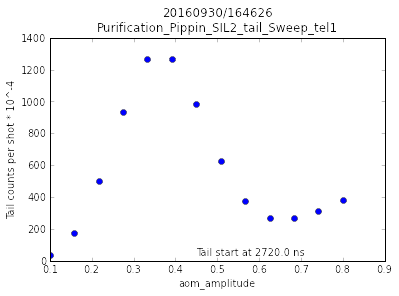

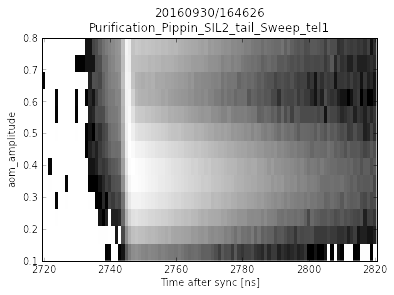

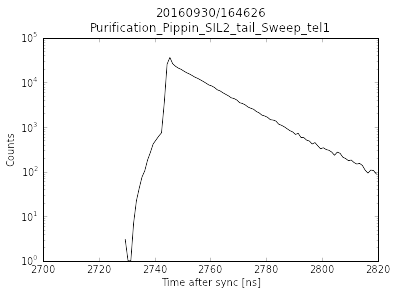

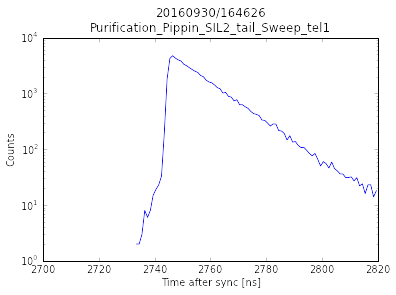

In [55]:
execfile(r'D:\measuring\analysis\scripts\setup_analysis.py')
%matplotlib inline

folder=tb.latest_data('tail_Sweep')
name = 'adwindata'

analyze_lt3 = True

# lt3 vs lt4 PSB

a = pqsequence.TailAnalysis(folder, hdf5_mode='r')#, pq_folder='bs_remote')

a.get_sweep_pts()
#a.sweep_pts = a.g.attrs['aom_amplitude']
a.get_sweep_idxs(noof_syncs_per_sweep_pt=250)
a.get_readout_results(name)
if analyze_lt3:
    if a.g.attrs['general_sweep_name']=='eom_off_amplitude':
        print 'sweeping EOM off voltage'
        a.get_tail_vs_sweep(0,2720,23, pq_binsize_ns=1, hist_binsize_ns=1.,verbose=True)
    else:
        a.get_tail_vs_sweep(0,2720,100, pq_binsize_ns=1, hist_binsize_ns=1.,verbose=True)

else:

    #a.get_tail_vs_sweep(0,5425.5,100, pq_binsize_ns=1e-3, hist_binsize_ns=1.,verbose=True)
    a.get_tail_vs_sweep(1,2750,100, pq_binsize_ns=1, hist_binsize_ns=1.,verbose=True)
    #a.get_tail_vs_sweep(1,0,5000, pq_binsize_ns=1, hist_binsize_ns=1.,verbose=True)


print 'Sweep tail.  from : {}\{} '.format(tb.timestamp_from_datetime(tb.get_datetime_from_folder(folder))[:8]\
                                                 ,tb.timestamp_from_datetime(tb.get_datetime_from_folder(folder))[8:])    
print 'optimum aom voltage : {:.3f}'.format(a.g.attrs['general_sweep_pts'][np.argmax(a.tail_cts_per_sweep_idx)]),\
    'with tail counts: {:.0f}e-4 counts/shot'.format(np.max(a.tail_cts_per_sweep_idx)*1e4)

print a.g.attrs['general_sweep_pts']
print a.reps
print a.syncs_per_sweep
print a.sweep_idxs

save=True
a.plot_tail_cts_vs_sweep(save=save, channels=1)
a.plot_tail_hists_vs_sweep(save=save,log_plot = False)
a.plot_tail_hist_integated(save=save, log_plot=True)
a.plot_tail_hist_all(save=save, log_plot=1, offset=0, indices=[np.argmax(a.tail_cts_per_sweep_idx)])

243260


(<matplotlib.figure.Figure at 0x3427a50>,
 (<matplotlib.axes._subplots.AxesSubplot at 0x3427bb0>,
  <matplotlib.axes._subplots.AxesSubplot at 0xdafa930>))

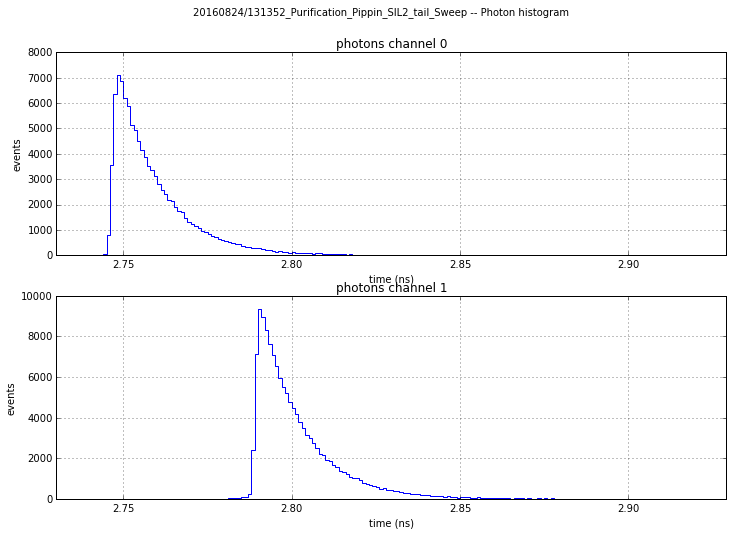

In [2]:
pq_plots.plot_photon_hist(a.pqf,start =2730,  length =200, hist_binsize = 1, save = False, log=False)

[0, 5.5999999999999999e-05, -0.02]


TypeError: 'int' object has no attribute '__getitem__'

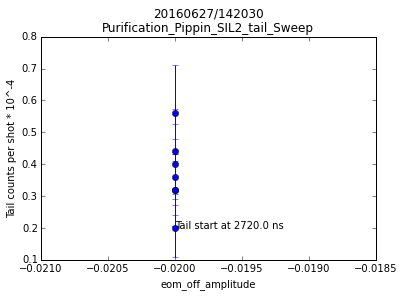

In [385]:
from analysis.lib.fitting import fit, common, rabi
ax=a.plot_tail_cts_vs_sweep(save=False, ret='ax')
x=a.g.attrs['general_sweep_pts']
y=a.tail_cts_per_sweep_idx
ff = common.fit_parabole
#o + A * (x-c)**2
#['g_o', 'g_A', 'g_c']
args = [0,np.max(y), x[np.argmin(y)]]
print args
fitres = fit.fit1d(x, y, ff, *args, fixed = [],
                   do_print = True, ret = True)
plot_pts=100
x_p=np.linspace(min(x),max(x),plot_pts)
if fitres['success']:
    f_p = fitres['fitfunc'](x_p)*1e4
    ax.plot(x_p,f_p)

NameError: name 'zeros' is not defined

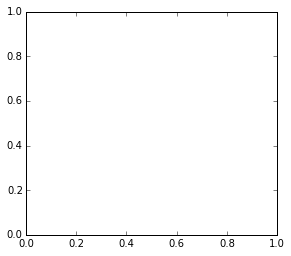

In [378]:
from analysis.lib.fitting import fit, common, rabi
from analysis.lib.tools import plot
fig, ax = plt.subplots(1,1, figsize=(4.5,4))
fs=zeros(a.sweep_length)
taus = zeros(a.sweep_length)
for i in range(a.sweep_length):
    x=a.tail_hist_b[:-1]        
    y=a.tail_hist_h[i]
    fit_result = fit.fit1d(x, y, rabi.fit_rabi_damped_exp_with_offset, 
            1/5.,1000,0,10., x[0], ret = True, color = 'r', linewidth = 2.0)
    fs[i] = fit_result['params_dict']['f']
    taus[i] = fit_result['params_dict']['tau']
    plot.plot_fit1d(fit_result, np.linspace(x[0],x[-1],201), ax=ax,
        plot_data=True, print_info=False)
fig, ax = plt.subplots(1,1, figsize=(4.5,4))
#print taus, fs
ax.plot(a.sweep_pts, fs)
fig, ax = plt.subplots(1,1, figsize=(4.5,4))
ax.plot(a.sweep_pts, taus)


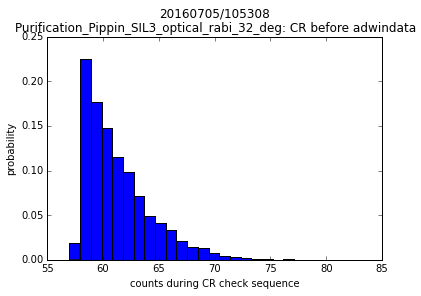

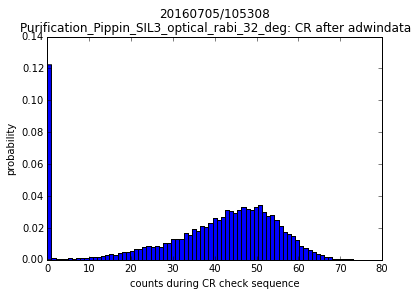

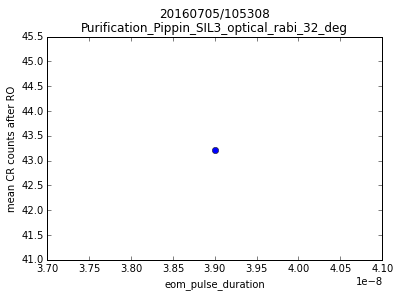

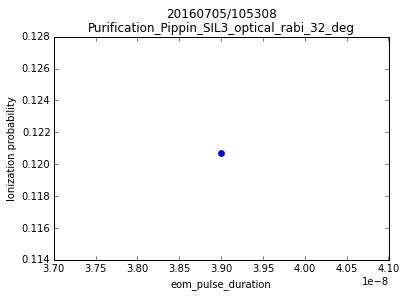

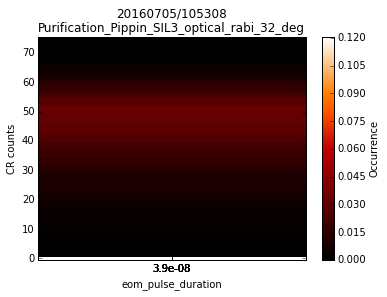

In [40]:

folder=tb.latest_data('32_deg')
name = 'adwindata'
TH_or_HH = 'TH'
a = pqsequence.TailAnalysis(folder, hdf5_mode='r')#, pq_folder='bs_remote')
a.get_cr_results(name,plot= True)
a.get_sweep_pts()
a.plot_cr_vs_sweep()

In [318]:
execfile(r'D:\measuring\analysis\scripts\setup_analysis.py')
#folder=tb.latest_data('Bell')
folder=tb.data_from_time('20141012023031')
#folder=r'D:\measuring\data\20140519\192030_Bell_lt3_tailS_The111no2_SIL1_Ey_+11deg'
name = 'ssro'
a = pqsequence.TailAnalysis(folder, hdf5_mode='r', pq_folder='bs_remote')
a.reps=200000
a.plot_histogram(0, start=5.350e6, length=1000000, hist_binsize=1000, save=False)

d:\measuring\data


TypeError: 'NoneType' object has no attribute '__getitem__'

In [7]:
from analysis.lib.pq import pq_tools
reload(pq_tools)

<module 'analysis.lib.pq.pq_tools' from 'd:/measuring\analysis\lib\pq\pq_tools.pyc'>

In [8]:
fltr0=pq_tools.filter_synctimes(a.pqf, 5371.5e3, 5397e3,15,600e3)
fltr1=pq_tools.filter_synctimes(a.pqf, 5374e3, 5399.5e3,15,600e3)
cs=pq_tools.get_coincidences(a.pqf, fltr0, fltr1)
dts_ns = cs[:,0]*1e-3
len(cs)

ValueError: Unable to create group (No write intent on file)

In [ ]:
binsize=10
G2_BINEDGES = arange(-19000,19000,binsize)
#G2_BINEDGES = np.hstack((arange(-700,-500,binsize),arange(-100,100,binsize),arange(500,700,binsize)))
#print G2_BINEDGES
figure(figsize=(20,5))
b_=hist(dts_ns, bins=G2_BINEDGES)

In [ ]:
execfile(r'D:\measuring\analysis\scripts\setup_analysis.py')
folder=tb.latest_data('Bell')
folder=tb.data_from_time('20140710153945')
a = sequence.SequenceAnalysis(folder)
a.get_cr_results(name)
a.get_sweep_pts()
a.plot_cr_vs_sweep()
a.finish()

Converged with chi squared  2.5843380949
degrees of freedom, dof  27
RMS of residuals (i.e. sqrt(chisq/dof))  0.309380390033
Reduced chisq (i.e. variance of residuals)  0.095716225737

fitted parameters at minimum, with 68% C.I.:
 0 a              0.141446 +/-   0.073668
 1 A             -0.180073 +/-   0.171715
 2 x0          5430.174360 +/-   3.709591
 3 T              4.713829 +/-   6.285561

correlation matrix:
               a         A         x0        T         
         a  1.000000
         A -0.341272  1.000000
        x0 -0.033615  0.113095  1.000000
         T  0.368512  0.399595  0.225398  1.000000



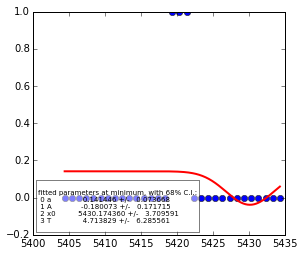

In [174]:
from analysis.lib.fitting import fit, common
from analysis.lib.tools import plot
fig, ax = plt.subplots(1,1, figsize=(4.5,4))
fs=np.zeros(a.sweep_length)
taus = np.zeros(a.sweep_length)
for i in range(a.sweep_length):
    x=a.tail_hist_b[:-1]        
    y=a.tail_hist_h[i]
    p0, fitfunc, fitfunc_str = common.fit_general_exponential(0.,300,5427.,2., 2.)
#     ax.plot(np.linspace(x[0],x[-1],201), fitfunc(np.linspace(x[0],x[-1],201)), ':', lw=2)
    fit_result = fit.fit1d(x, y, None, p0=p0, fitfunc=fitfunc, 
            ret = True, color = 'r', linewidth = 2.0,fixed=[4],do_print=True)
    
    plot.plot_fit1d(fit_result, np.linspace(x[0],x[-1],201), ax=ax,
        plot_data=True, print_info=True)
#     fs[i] = fit_result['params_dict']['f']
#     taus[i] = fit_result['params_dict']['tau']
# fig, ax = plt.subplots(1,1, figsize=(4.5,4))
# #print taus, fs
# ax.plot(a.sweep_pts, fs)
# fig, ax = plt.subplots(1,1, figsize=(4.5,4))
# ax.plot(a.sweep_pts, taus)

In [ ]:
624-166

In [36]:
tau = 10.886 # us
NPulse = 12
C13Gate = 2*NPulse*tau
trigger = 467.623 # us
phase_gate = 8*2*0.161
avg_rep_time = 0.22
duration_in_awg = 1+2*C13Gate+phase_gate+trigger + avg_rep_time
print duration_in_awg

993.947
